In [ ]:
# Multi-Layer Perceptron Neural Network

import numpy as np

class NeuralNetwork:

    def __init__(self, layers=[2, 2, 2, 1]):  # [input_size, hidden_layer1_size, hidden_layer2_size, ..., output_size]
        # Dataset (Inputs: 2, Samples: 3)
        self.x_dataset = np.array([[2, 6], [8, 5], [1, 2]])
        self.y_value = np.array([[1], [1], [0]])

        self.x_weights = []
        self.x_bias = []

        for i in range(len(layers) - 1):
            # Xavier Initialization: np.sqrt(1 / nodes_in)
            limit = np.sqrt(1 / layers[i])
            w = np.random.uniform(-limit, limit, (layers[i+1], layers[i]))
            b = np.zeros(layers[i+1])
            
            self.x_weights.append(w)
            self.x_bias.append(b)

       
        self.output_weights = self.x_weights.pop()
        self.output_bias = self.x_bias.pop()

        self.learning_rate = 0.1
        self.tolerance = 1e-6  # minimum change in loss
        self.prev_loss = float('inf')




    # xavier intialization of the vanishing gradients
    @staticmethod
    def xavier_intialization():
        pass


    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def derivative_sgimoid(x):
        return x * (1 - x)
    
    def predict(self, new_data):
        dataset = np.atleast_2d(new_data)

        for w,b in zip(self.x_weights, self.x_bias):
            neuron = (dataset @ w.T) + b
            dataset = self.sigmoid(neuron)

        return self.sigmoid(dataset @ self.output_weights.T + self.output_bias)
    
    def train(self, epochs = 5):
         
        for i in range(epochs):
            activations, prediction = self.forward_propagation()

            # - (true value * log( predited value ) + (1 - true value)  * log(1 - predicted value) )
            loss = -np.mean(self.y_value * np.log(prediction) + (1 - self.y_value) * np.log(1 - prediction))

            if abs(self.prev_loss - loss) < self.tolerance:
                print(f"Stopping at iteration {i + 1}, loss change < {self.tolerance} : {abs(self.prev_loss - loss)}")
                break
            
            self.back_propagation(activations, prediction)
            self.prev_loss = loss
        return prediction

                
    # FORWARD PROPAGATION 
    def forward_propagation(self):
        dataset = self.x_dataset
        activations = []  # Store all hidden layers activations values

       
        for w,b in zip(self.x_weights, self.x_bias): # Basically getting the length of the list
            neuron = ( dataset @ w.T) + b  # ( Hidden layer Weights * Inputs ) + Bias
            activation = self.sigmoid(neuron)  # Sigmoid ( neuron )
            dataset = activation # Re-assign the input as the activation of the previous layer 
            activations.append(dataset) # Collecting all activations of each layers

        # Sigmoid ( ( output_weights * last layer activation ) + output_bias )
        prediction = self.sigmoid(dataset @ self.output_weights.T + self.output_bias)
        return activations, prediction


    # BACKPROPAGATION
    def back_propagation(self, activations, prediction):
        batch_size = self.x_dataset.shape[0]
        
        # output delta = predicted value - true value
        output_delta = prediction - self.y_value

        # output delta * last activation value / batch_size
        output_dw = (output_delta.T @ activations[-1]) / batch_size
        output_db = np.sum(output_delta, axis=0) / batch_size # output gradient bias


        hidden_dw = []
        hidden_db = []
        delta = output_delta

        # calculate the backdrop error and gradient of each hidden layer = W.T * delta * derivative of sigmoid (activation)
        for i in reversed(range(len(self.x_weights))):
            if i == len(self.x_weights) - 1:
                # last hidden layer -> output
                delta = (delta @ self.output_weights) * self.derivative_sgimoid(activations[i])
            else:
                delta = (delta @ self.x_weights[i + 1]) * self.derivative_sgimoid(activations[i])
            

            prev_activation = self.x_dataset if i == 0 else activations[i - 1]
            hidden_dw.insert(0, ((delta.T @ prev_activation) / batch_size))
            hidden_db.insert(0, np.sum(delta, axis=0) / batch_size)

        # update the output weight and bias = old weight - ( learning_rate * gradient )
        self.output_weights -= self.learning_rate * output_dw 
        self.output_bias -= self.learning_rate * output_db

         # update the hidden layer weight and bias = old weight - ( learning_rate * gradient )
        for i in range(len(self.x_weights)):
            self.x_weights[i] -= self.learning_rate * hidden_dw[i]
            self.x_bias[i] -= self.learning_rate * hidden_db[i]
        return True



train = NeuralNetwork()
train.train(epochs=1)

test_pass = train.predict([8, 6])
print(f"Pass Probability: {test_pass[0][0]:.4f}")


Pass Probability: 0.4035


In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist

x = np.array([
    [1, 0],
    [1, 1]
])

y = np.array([1, 0, 0])

class Mnist:

    def __init__(self, input_size=784, output_size=10, layers=2, hidden_size=128):
        self.layers = layers
        self.w = [
            np.random.randn(hidden_size, input_size if i == 0 else hidden_size)
            * np.sqrt(2.0 / (input_size if i == 0 else hidden_size))
            for i in range(layers)
        ]   
        self.b = [np.zeros(hidden_size) for _ in range(layers)]
        self.output_w = np.random.randn(output_size, hidden_size) * 0.01
        self.output_b = np.zeros(output_size)
        self.learning_rate = 0.001
        self.prev_loss = float('inf')
        self.tolerance = 1e-6 

    @classmethod
    def relu(cls,x):
        return np.maximum(0, x)
    
    @classmethod
    def derivative_relu(cls, x):
        return (x > 0).astype(int)
    
    @classmethod
    def softmax(cls, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)


    def forward_propagation(self, x):
        self.pre_activations = []
        self.activations = []
        for w, b in zip(self.w, self.b):
            z = x @ w.T + b
            x = self.relu(z)
            self.pre_activations.append(z)
            self.activations.append(x)
        output = x @ self.output_w.T + self.output_b
        return self.softmax(output)


    def back_propagation(self, x_inputs, y_prediction, labels):
        batch_size = labels.shape[0]
        delta = y_prediction - labels
        
        self.output_w -= self.learning_rate  * (delta.T @ self.activations[-1] / batch_size)
        self.output_b -= self.learning_rate * (np.sum(delta, axis=0) / batch_size)

        for x in reversed(range(len(self.w))):
            
            if x == len(self.w) - 1:
                delta = delta @ self.output_w  * self.derivative_relu(self.pre_activations[x])
            else:
                delta = delta @ self.w[x + 1] * self.derivative_relu(self.pre_activations[x])
            
            activations = x_inputs if x == 0 else self.activations[x - 1]
            
            self.w[x] -= self.learning_rate * ( delta.T @ activations / batch_size)
            self.b[x] -= self.learning_rate * ( np.sum(delta, axis=0) / batch_size )

    def train(self, x_train, y_train, batch_size=64, epochs=10):

        for epoch in range(epochs):

            for i in range(0, len(x_train), batch_size):
                x_batch = x_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                prediction = self.forward_propagation(x_batch)

                # - (true value * log( predited value ) + (1 - true value)  * log(1 - predicted value) )
                loss = -np.mean(np.sum(y_batch * np.log(prediction + 1e-8), axis=1))

                self.back_propagation(x_batch, prediction, y_batch)

                print(f"Epoch {epoch} - Batch {i} : Loss is {loss}")


    def predict(self,x_test, y_test):
        pred = self.forward_propagation(x_test)
        predicted_digit = np.argmax(pred, axis=1)
        true_digit = np.argmax(y_test, axis=1)

        accuracy = np.mean(predicted_digit == true_digit)
        print("Accuracy:", accuracy)

model = Mnist()

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784) / 255.0
x_test = x_test.reshape(-1, 784) / 255.0
y_train_oh = np.eye(10)[y_train]
y_test_oh = np.eye(10)[y_test]
model.train(x_train, y_train_oh, epochs=20)
model.predict(x_test, y_test_oh)






Epoch 0 : Loss is 2.2927073452041435
Epoch 0 : Loss is 2.2923405835108634
Epoch 0 : Loss is 2.295055645773634
Epoch 0 : Loss is 2.294230879489003
Epoch 0 : Loss is 2.297874384037139
Epoch 0 : Loss is 2.290515280283098
Epoch 0 : Loss is 2.2928141913022766
Epoch 0 : Loss is 2.298498414649866
Epoch 0 : Loss is 2.298590886348398
Epoch 0 : Loss is 2.3039943105925245
Epoch 0 : Loss is 2.3009538125824487
Epoch 0 : Loss is 2.293496661172943
Epoch 0 : Loss is 2.2976846289064623
Epoch 0 : Loss is 2.293049452212278
Epoch 0 : Loss is 2.302011267599167
Epoch 0 : Loss is 2.2934341512273573
Epoch 0 : Loss is 2.292461414854352
Epoch 0 : Loss is 2.295681729383456
Epoch 0 : Loss is 2.2932424591146865
Epoch 0 : Loss is 2.2956502999782287
Epoch 0 : Loss is 2.2978177056272346
Epoch 0 : Loss is 2.2930403059996087
Epoch 0 : Loss is 2.2925174665857293
Epoch 0 : Loss is 2.295434175277646
Epoch 0 : Loss is 2.2932790441672357
Epoch 0 : Loss is 2.292726088816215
Epoch 0 : Loss is 2.2873744417670636
Epoch 0 : Loss

[[6.24318497e-02 2.50079127e-04 3.15788407e-01 7.98229537e-02
  6.26226792e-03 1.27582761e-01 1.79573940e-02 8.60371709e-03
  3.52011500e-01 2.92890700e-02]]


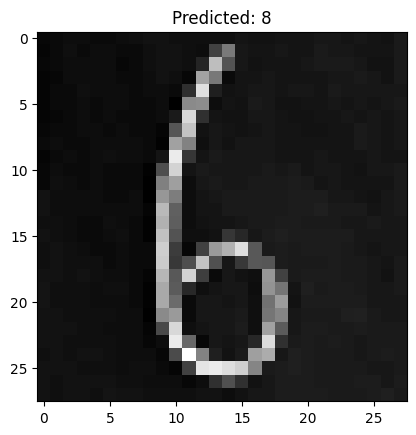

In [209]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load your handwritten image
img = Image.open("six.png").convert("L")  # grayscale
img = img.resize((28, 28))  # MNIST size

img_array = np.array(img)

# Invert colors if necessary (MNIST is white digit on black)
if np.mean(img_array) > 127:  # simple heuristic
    img_array = 255 - img_array

# Normalize to 0-1
img_array = img_array / 255.0

# Flatten and add batch dimension
img_array = img_array.reshape(1, 784)

# Forward pass
pred = model.forward_propagation(img_array)
print(pred)
digit = np.argmax(pred)

# Visualize
plt.imshow(img_array.reshape(28, 28), cmap="gray")
plt.title(f"Predicted: {digit}")
plt.show()
